In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report,precision_recall_fscore_support, average_precision_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

RANDOM_STATE = 42

In [3]:
# Load data
users = pd.read_csv('takehome_users.csv', encoding='latin1')
engagement = pd.read_csv("takehome_user_engagement.csv")

In [4]:
# Convert timestamp to datetime
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [5]:
def is_adopted(login_dates):
    login_dates = pd.Series(login_dates).sort_values(ascending=True).reset_index(drop=True)
    for i in range(len(login_dates) - 2):
        if (login_dates[i + 2] - login_dates[i]).days <= 7:
            return True
    return False

# Identify adopted users
adopted_user_ids = []
for user_id, group in engagement.groupby('user_id'):
    login_dates = group['time_stamp'].dt.date
    if is_adopted(login_dates):
        adopted_user_ids.append(user_id)

# Merge adoption info into user data
users['adopted'] = users['object_id'].isin(adopted_user_ids)
users['invited'] = users['invited_by_user_id'].notnull()
users['creation_year'] = users['creation_time'].dt.year
users['org_size'] = users.groupby('org_id')['object_id'].transform('count')
users['org_size_quartile'] = pd.qcut(users['org_size'], 4, labels=False, duplicates='drop')

In [6]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited,creation_year,org_size,org_size_quartile
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False,True,2014,75,3
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True,True,2013,233,3
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False,True,2013,32,2
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False,True,2013,233,3
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False,True,2013,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,False,True,2013,40,2
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,False,False,2013,25,1
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,False,True,2014,27,1
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,False,False,2012,138,3


In [7]:
# Analyze adoption by factors
adoption_by_invitation = users.groupby('invited')['adopted'].mean()
adoption_by_year = users.groupby('creation_year')['adopted'].mean()
adoption_by_org_size = users.groupby(pd.qcut(users['org_size'], 4), observed=False)['adopted'].mean()

# Print results
print("Adoption by invitation:")
print(adoption_by_invitation)
print("\nAdoption by creation year:")
print(adoption_by_year)
print("\nAdoption by organization size quartile:")
print(adoption_by_org_size)

Adoption by invitation:
invited
False    0.127709
True     0.146953
Name: adopted, dtype: float64

Adoption by creation year:
creation_year
2012    0.167322
2013    0.154158
2014    0.088744
Name: adopted, dtype: float64

Adoption by organization size quartile:
org_size
(1.999, 21.0]    0.171544
(21.0, 29.0]     0.149332
(29.0, 55.0]     0.135857
(55.0, 319.0]    0.093195
Name: adopted, dtype: float64


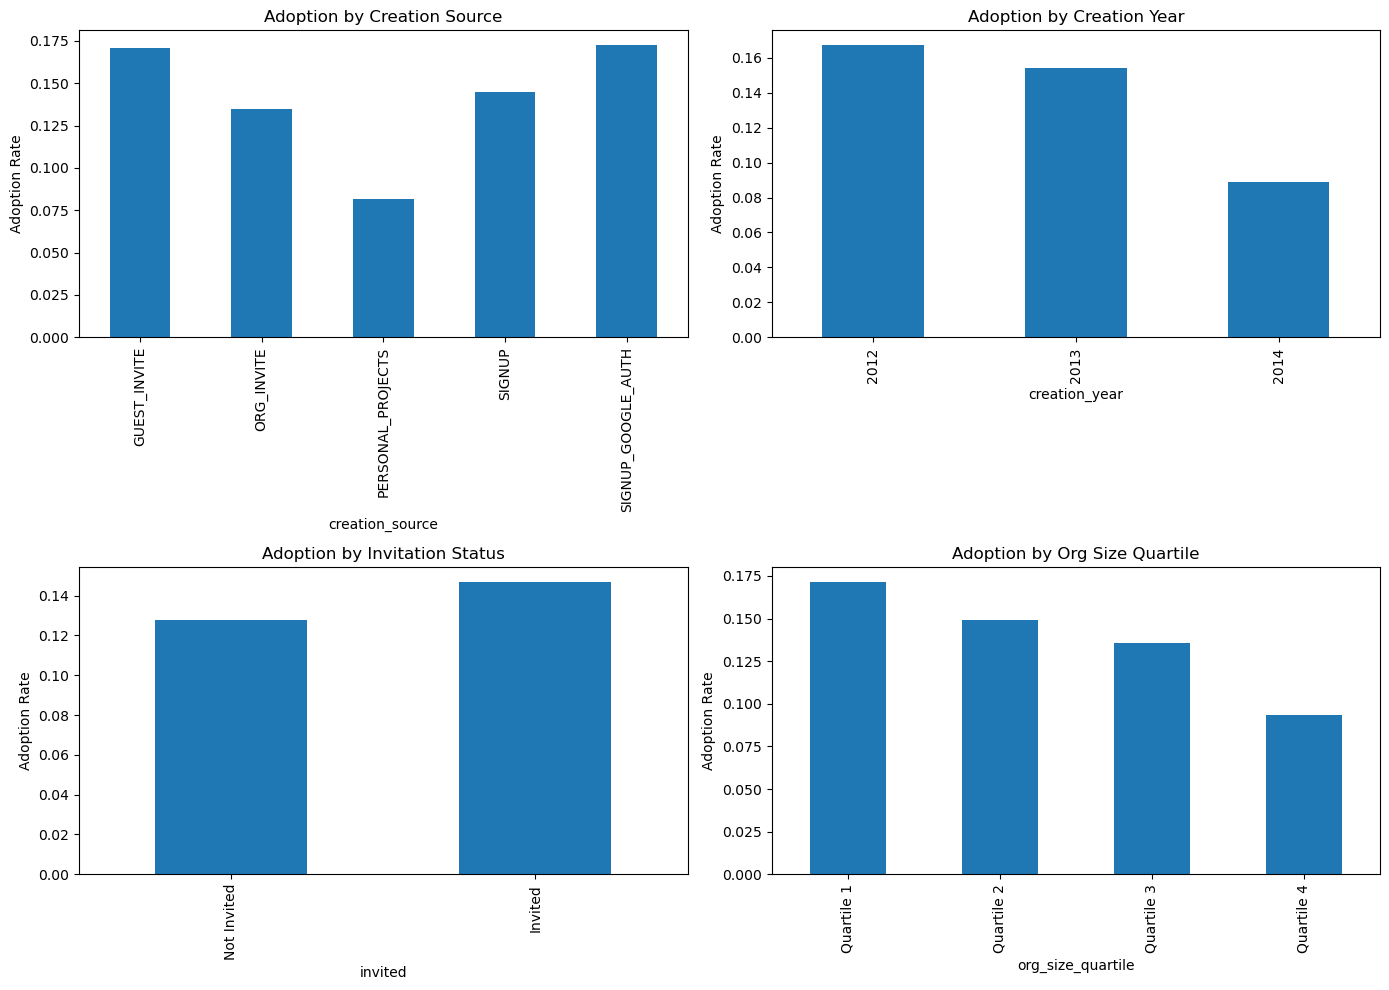

In [8]:
# Plot adoption rates
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Adoption by creation source
source_adoption = users.groupby('creation_source')['adopted'].mean()
source_adoption.plot(kind='bar', ax=axes[0,0], title='Adoption by Creation Source', ylabel='Adoption Rate')

# Adoption by creation year
year_adoption = users.groupby('creation_year')['adopted'].mean()
year_adoption.plot(kind='bar', ax=axes[0,1], title='Adoption by Creation Year', ylabel='Adoption Rate')

# Adoption by invitation status
invited_adoption = users.groupby('invited')['adopted'].mean()
invited_adoption.index = invited_adoption.index.map({True:'Invited', False:'Not Invited'})
invited_adoption.plot(kind='bar', ax=axes[1,0], title='Adoption by Invitation Status', ylabel='Adoption Rate')

# Adoption by organization size quartile
quartile_adoption = users.groupby('org_size_quartile')['adopted'].mean()
quartile_adoption.index = quartile_adoption.index.map(lambda x: f'Quartile {int(x)+1}')
quartile_adoption.plot(kind='bar', ax=axes[1,1], title='Adoption by Org Size Quartile', ylabel='Adoption Rate')

plt.tight_layout()
plt.savefig('adoption_charts.png')
plt.show()


In [9]:
users.head(2)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited,creation_year,org_size,org_size_quartile
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False,True,2014,75,3
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True,True,2013,233,3


In [10]:
candidate_features = [
    'invited_by_user_id',
    'org_id',
    'last_session_creation_time',
    'invited',                         
    'opted_in_to_mailing_list',       
    'enabled_for_marketing_drip',
    'creation_year',
    'org_size',
    'org_size_quartile',
    'creation_source'                  
]

X = users[candidate_features].copy()
y = users['adopted'].astype(int)

for bcol in [c for c in ['invited','opted_in_to_mailing_list','enabled_for_marketing_drip'] if c in X.columns]:
    X[bcol] = X[bcol].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

In [11]:
#Preprocessing and model pipelines

categorical_features = [c for c in ['creation_source'] if c in X.columns]
numeric_features = [c for c in X.columns if c not in categorical_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [12]:
# Logistic Regression
log_reg_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(
        max_iter=2000,
        solver='liblinear',
        class_weight='balanced',
        random_state=RANDOM_STATE
    ))
])

# Random Forest
rf_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

In [13]:
#Train and Evaluate

def evaluate_model(name, pipeline, X_train, y_train, X_test, y_test, plot_prefix):
    pipeline.fit(X_train, y_train)

    y_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)  # area under PR curve
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)

    print(f"\n=== {name} ===")
    print(f"ROC-AUC: {auc:.4f} | Avg Precision (PR AUC): {ap:.4f}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))

    return pipeline, y_proba, auc

In [14]:
# Cross-validated AUC
def cv_auc(pipeline, X, y, folds=5):
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(f"CV ROC-AUC ({folds} folds): {scores.mean():.4f} ± {scores.std():.4f}")

In [15]:
print("\n[Logistic Regression] Cross-validated training AUC:")
cv_auc(log_reg_clf, X_train, y_train)

print("\n[Random Forest] Cross-validated training AUC:")
cv_auc(rf_clf, X_train, y_train)


[Logistic Regression] Cross-validated training AUC:
CV ROC-AUC (5 folds): 0.8793 ± 0.0107

[Random Forest] Cross-validated training AUC:
CV ROC-AUC (5 folds): 0.9347 ± 0.0050


In [16]:
# Fit and evaluate on test
log_reg_clf, lr_proba, lr_auc = evaluate_model('Logistic Regression', log_reg_clf, X_train, y_train, X_test, y_test, 'lr')
rf_clf, rf_proba, rf_auc = evaluate_model('Random Forest', rf_clf, X_train, y_train, X_test, y_test, 'rf')


=== Logistic Regression ===
ROC-AUC: 0.8615 | Avg Precision (PR AUC): 0.7058
Precision: 0.4212 | Recall: 0.7874 | F1: 0.5488

Confusion Matrix:
[[2138  448]
 [  88  326]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9605    0.8268    0.8886      2586
           1     0.4212    0.7874    0.5488       414

    accuracy                         0.8213      3000
   macro avg     0.6908    0.8071    0.7187      3000
weighted avg     0.8860    0.8213    0.8417      3000


=== Random Forest ===
ROC-AUC: 0.9166 | Avg Precision (PR AUC): 0.8249
Precision: 0.9062 | Recall: 0.6304 | F1: 0.7436

Confusion Matrix:
[[2559   27]
 [ 153  261]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9436    0.9896    0.9660      2586
           1     0.9062    0.6304    0.7436       414

    accuracy                         0.9400      3000
   macro avg     0.9249    0.8100    0.8548      3000
weighted avg   

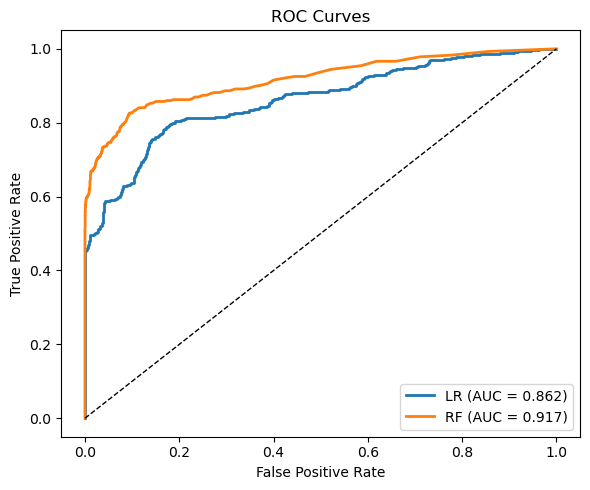

In [17]:
    # ROC curve
    fpr1, tpr1, _ = roc_curve(y_test, lr_proba)
    fpr2, tpr2, _ = roc_curve(y_test, rf_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr1, tpr1, label=f'LR (AUC = {lr_auc:.3f})', lw=2)
    plt.plot(fpr2, tpr2, label=f'RF (AUC = {rf_auc:.3f})', lw=2)
    plt.plot([0,1],[0,1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [18]:
#Get transformed feature names
def get_feature_names(preprocess_ct):
    names = preprocess_ct.get_feature_names_out()
    return list(names)


In [19]:
# Feature importance: LR

def plot_top_importances(names, values, title, top_k=20, absolute=False):
    order = np.argsort(np.abs(values))[::-1][:top_k]
    imp_names = [names[i] for i in order]
    imp_vals = np.abs(values[order])

    plt.figure(figsize=(8, max(5, 0.35*len(imp_names))))
    sns.barplot(x=imp_vals, y=imp_names, orient='h', color='#4472C4')
    plt.title(title)
    plt.xlabel('Importance' + (' (|coef|)' if absolute else ''))
    plt.ylabel('')
    plt.tight_layout()
    plt.show()


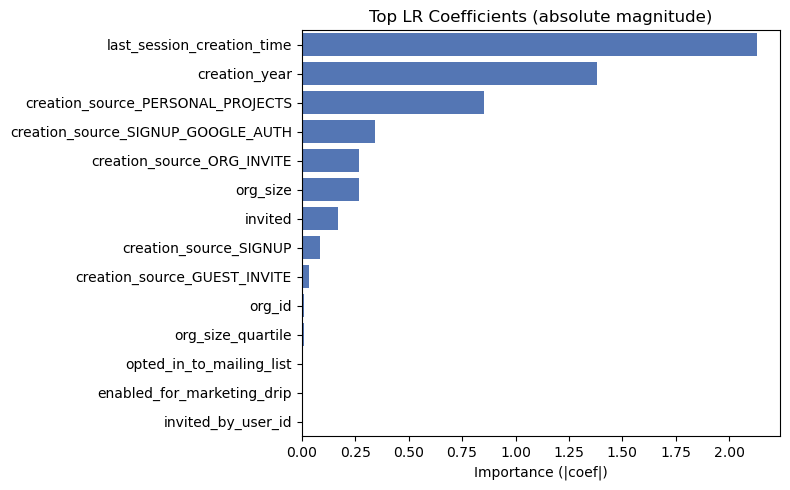

In [20]:
# LR coefficients
lr_model = log_reg_clf.named_steps['model']
lr_feature_names = get_feature_names(log_reg_clf.named_steps['preprocess'])
lr_coefs = lr_model.coef_.ravel()

plot_top_importances(
    lr_feature_names, lr_coefs,
    title='Top LR Coefficients (absolute magnitude)',
    top_k=20,
    absolute=True
)

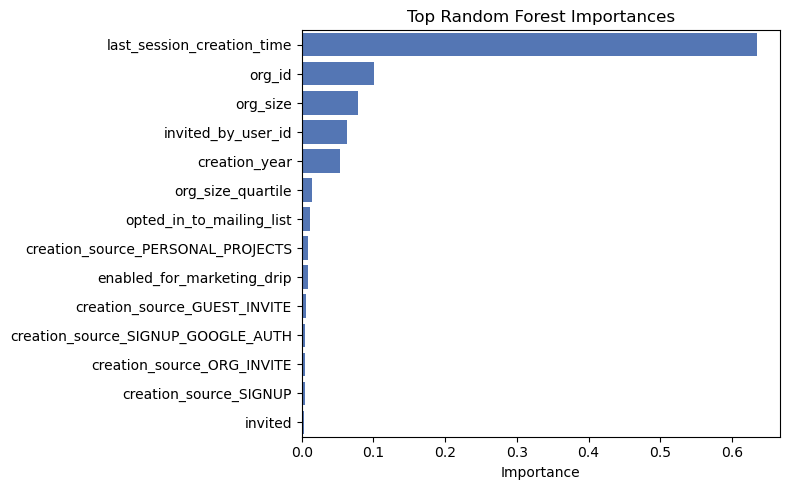

In [21]:
#Feature importance: RF

rf_model = rf_clf.named_steps['model']
rf_feature_names = get_feature_names(rf_clf.named_steps['preprocess'])
rf_importances = rf_model.feature_importances_

plot_top_importances(
    rf_feature_names, rf_importances,
    title='Top Random Forest Importances',
    top_k=20,
    absolute=False
)

In [22]:
# Permutation importance

def compute_and_plot_permutation_importance(pipeline, X_test, y_test, title_prefix, top_k=20):
    result = permutation_importance(
        pipeline, X_test, y_test,
        n_repeats=10,
        random_state=RANDOM_STATE,
        scoring='roc_auc',
        n_jobs=-1
    )
    names = get_feature_names(pipeline.named_steps['preprocess'])
    importances_mean = result.importances_mean
    plot_top_importances(
        names, importances_mean,
        title=f'{title_prefix} - Permutation Importance',
        top_k=top_k,
        absolute=False
    )

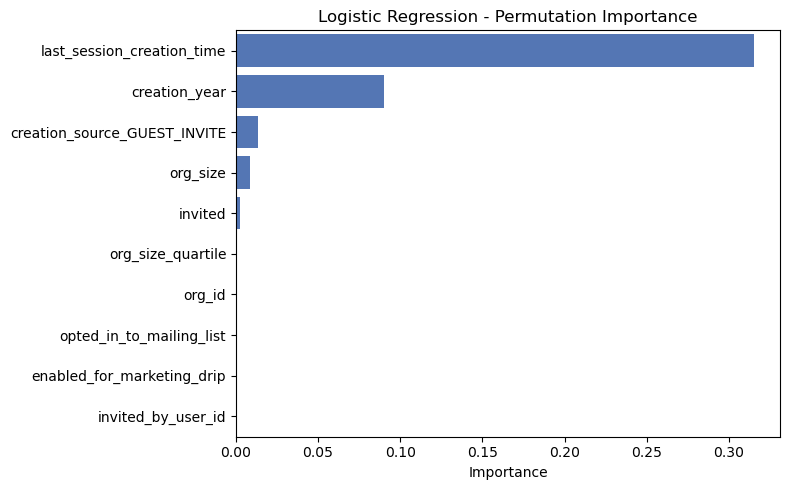

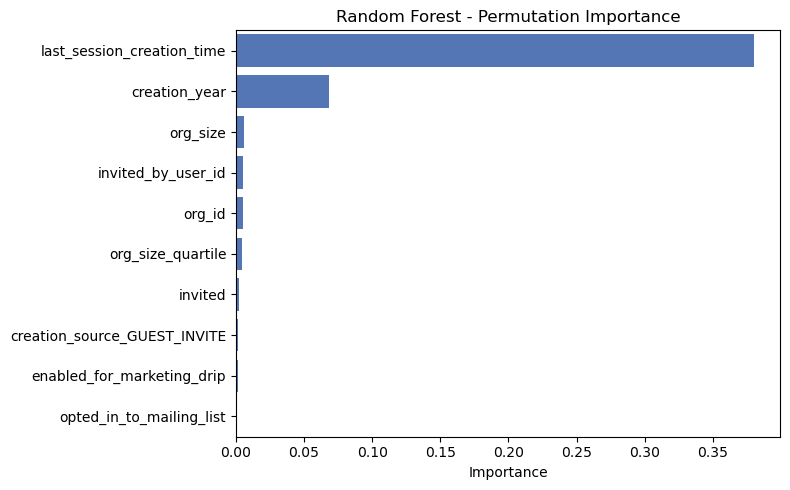

In [23]:
compute_and_plot_permutation_importance(
    log_reg_clf, X_test, y_test,
    title_prefix='Logistic Regression',
    top_k=20
)

compute_and_plot_permutation_importance(
    rf_clf, X_test, y_test,
    title_prefix='Random Forest',
    top_k=20
)


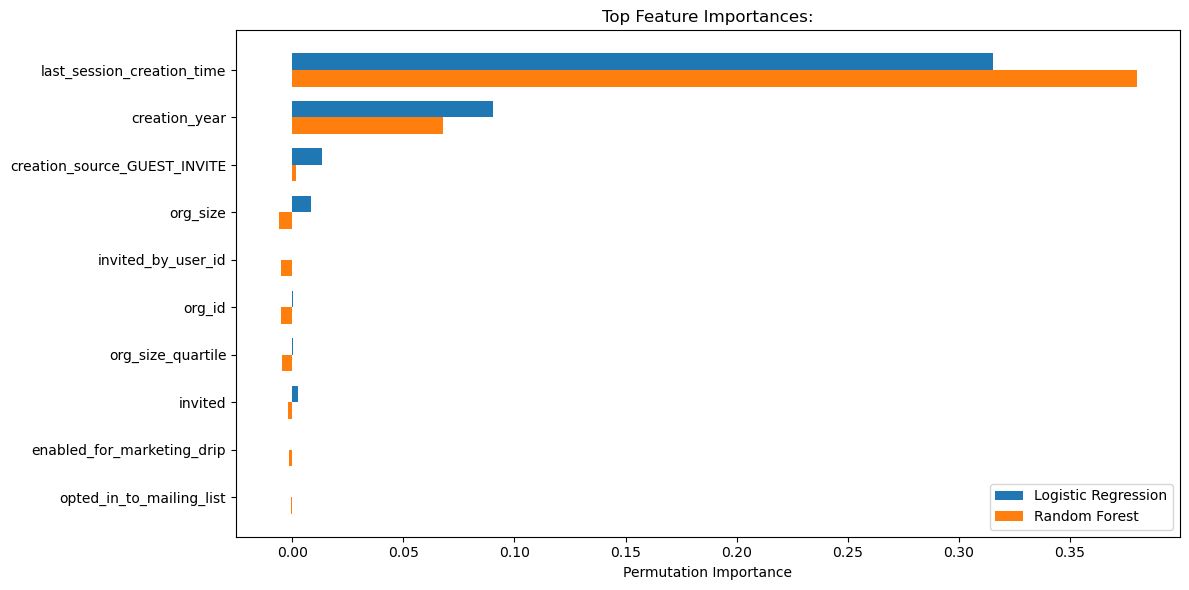

In [24]:

def compute_permutation_importance(pipeline, X_test, y_test, random_state=42):
    result = permutation_importance(
        pipeline, X_test, y_test,
        n_repeats=10,
        random_state=random_state,
        scoring='roc_auc',
        n_jobs=-1
    )
    names = get_feature_names(pipeline.named_steps['preprocess'])
    return dict(zip(names, result.importances_mean))

def plot_combined_importance(log_reg_importances, rf_importances, top_k=20):
    all_features = set(log_reg_importances.keys()).union(rf_importances.keys())
    combined = {
        feature: (log_reg_importances.get(feature, 0), rf_importances.get(feature, 0))
        for feature in all_features
    }
    sorted_features = sorted(
        combined.items(),
        key=lambda x: max(abs(x[1][0]), abs(x[1][1])),
        reverse=True
    )[:top_k]

    features = [f[0] for f in sorted_features]
    log_vals = [f[1][0] for f in sorted_features]
    rf_vals = [f[1][1] for f in sorted_features]
    x = np.arange(len(features))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(x - width/2, log_vals, width, label='Logistic Regression')
    ax.barh(x + width/2, rf_vals, width, label='Random Forest')

    ax.set_yticks(x)
    ax.set_yticklabels(features)
    ax.invert_yaxis()
    ax.set_xlabel('Permutation Importance')
    ax.set_title('Top Feature Importances:')
    ax.legend()
    plt.tight_layout()
    plt.show()


log_reg_importances = compute_permutation_importance(log_reg_clf, X_test, y_test)
rf_importances = compute_permutation_importance(rf_clf, X_test, y_test)
plot_combined_importance(log_reg_importances, rf_importances, top_k=20)